In [1]:
import math
import os
import time
import urllib.request
from dataclasses import dataclass
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


In [19]:
# =========================
# 0) Config
# =========================

class CFG:
    # data
    data_path: str = "tinyshakespeare.txt"
    url: str = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

    # training
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size: int = 64
    block_size: int = 128*2          # context length (N)
    max_iters: int = 10000
    eval_every: int = 1000
    lr: float = 3e-4
    weight_decay: float = 0.01
    grad_clip: float = 1.0

    # model
    n_layers: int = 4
    n_heads: int = 4
    d_model: int = 256             # D
    d_ff: int = 4 * 256            # MLP hidden
    dropout: float = 0.1


cfg = CFG()

In [11]:
# =========================
# 1) Get dataset
# =========================
def ensure_data(cfg: CFG):
    if os.path.exists(cfg.data_path):
        return
    print(f"Downloading dataset to {cfg.data_path} ...")
    urllib.request.urlretrieve(cfg.url, cfg.data_path)
    print("Done.")


def load_text(path: str) -> str:
    with open(path, "r", encoding="utf-8") as f:
        return f.read()


In [21]:
# =========================
# 2) Char tokenizer
# =========================
class CharVocab:
    def __init__(self, text: str):
        chars = sorted(list(set(text)))
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(chars)

    def encode(self, s: str):
        return [self.stoi[c] for c in s]

    def decode(self, ids):
        return "".join(self.itos[i] for i in ids)

# ========================
class CharVocab:
    """
    Character-level tokenizer with special tokens and error handling.
    
    Usage:
        vocab = CharVocab(text)
        ids = vocab.encode("hello")        # [5, 2, 9, 9, 12]
        text = vocab.decode(ids)           # "hello"
        ids = vocab.encode("xyz§")         # unknown '§' → [UNK] token
    """

    # Special tokens
    PAD_TOKEN = "<PAD>"   # padding for batching
    UNK_TOKEN = "<UNK>"   # unknown characters
    BOS_TOKEN = "<BOS>"   # beginning of sequence
    EOS_TOKEN = "<EOS>"   # end of sequence

    def __init__(self, text: str):
        special = [self.PAD_TOKEN, self.UNK_TOKEN, self.BOS_TOKEN, self.EOS_TOKEN]
        chars = special + sorted(set(text))

        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(chars)

        # Quick access to special token IDs
        self.pad_id = self.stoi[self.PAD_TOKEN]
        self.unk_id = self.stoi[self.UNK_TOKEN]
        self.bos_id = self.stoi[self.BOS_TOKEN]
        self.eos_id = self.stoi[self.EOS_TOKEN]

    def encode(self, s: str, add_special=False, max_length=None):
        """
        Encode string → list of token IDs.

        Args:
            s: input string
            add_special: wrap with <BOS> and <EOS>
            max_length: pad/truncate to fixed length

        Examples:
            vocab.encode("hi")                          → [5, 6]
            vocab.encode("hi", add_special=True)        → [2, 5, 6, 3]
            vocab.encode("hi", max_length=5)            → [5, 6, 0, 0, 0]
        """
        ids = [self.stoi.get(c, self.unk_id) for c in s]

        if add_special:
            ids = [self.bos_id] + ids + [self.eos_id]

        if max_length is not None:
            ids = ids[:max_length]                          # truncate
            ids = ids + [self.pad_id] * (max_length - len(ids))  # pad

        return ids

    def decode(self, ids, strip_special=True):
        """
        Decode list of token IDs → string.

        Args:
            ids: list of ints or tensor
            strip_special: remove PAD/BOS/EOS from output
        """
        # Handle tensors
        if hasattr(ids, 'tolist'):
            ids = ids.tolist()

        special_ids = {self.pad_id, self.bos_id, self.eos_id}
        chars = []
        for i in ids:
            if strip_special and i in special_ids:
                continue
            chars.append(self.itos.get(i, "?"))

        return "".join(chars)

    def __len__(self):
        return self.vocab_size

    def __repr__(self):
        return f"CharVocab(size={self.vocab_size}, chars={''.join(self.itos[i] for i in range(4, min(24, self.vocab_size)))}...)"

In [13]:
# =========================
# 3) Data batching
# =========================
def make_splits(data_ids: torch.Tensor, train_frac=0.9):
    n = int(len(data_ids) * train_frac)
    return data_ids[:n], data_ids[n:]


def get_batch(data_ids: torch.Tensor, cfg: CFG):
    # sample random positions
    ix = torch.randint(0, len(data_ids) - cfg.block_size - 1, (cfg.batch_size,))
    x = torch.stack([data_ids[i:i + cfg.block_size] for i in ix])
    y = torch.stack([data_ids[i + 1:i + cfg.block_size + 1] for i in ix])
    return x.to(cfg.device), y.to(cfg.device)


@torch.no_grad()
def estimate_loss(model, train_ids, val_ids, cfg: CFG, iters=50):
    model.eval()
    out = {}
    for split, ids in [("train", train_ids), ("val", val_ids)]:
        losses = []
        for _ in range(iters):
            x, y = get_batch(ids, cfg)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

In [14]:
# =========================
# 4) Transformer building blocks (from scratch)
# =========================
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, block_size, dropout):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # combined QKV projection (one matmul)
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

        # causal mask (precomputed)
        mask = torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
        self.register_buffer("mask", mask)  # not a parameter

    def forward(self, x):
        # x: (B, N, D)
        B, N, D = x.shape

        qkv = self.qkv(x)  # (B, N, 3D)
        q, k, v = qkv.split(D, dim=2)  # each (B, N, D)

        # reshape to heads
        q = q.view(B, N, self.n_heads, self.d_head).transpose(1, 2)  # (B, H, N, Dh)
        k = k.view(B, N, self.n_heads, self.d_head).transpose(1, 2)  # (B, H, N, Dh)
        v = v.view(B, N, self.n_heads, self.d_head).transpose(1, 2)  # (B, H, N, Dh)

        # scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B, H, N, N)

        # causal mask: prevent attending to future tokens
        att = att.masked_fill(self.mask[:, :, :N, :N] == 0, float("-inf"))

        w = F.softmax(att, dim=-1)              # (B, H, N, N)
        w = self.dropout(w)

        y = w @ v                               # (B, H, N, Dh)
        y = y.transpose(1, 2).contiguous().view(B, N, D)  # concat heads -> (B, N, D)

        y = self.proj(y)
        y = self.dropout(y)
        return y


In [15]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """
    Pre-LN Transformer block:
    x = x + Attn(LN(x))
    x = x + MLP(LN(x))
    """
    def __init__(self, d_model, n_heads, block_size, d_ff, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, block_size, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = FeedForward(d_model, d_ff, dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class TinyGPT(nn.Module):
    def __init__(self, vocab_size, cfg: CFG):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = cfg.block_size

        self.tok_emb = nn.Embedding(vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.block_size, cfg.d_model)
        self.drop = nn.Dropout(cfg.dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(cfg.d_model, cfg.n_heads, cfg.block_size, cfg.d_ff, cfg.dropout)
            for _ in range(cfg.n_layers)
        ])
        self.ln_f = nn.LayerNorm(cfg.d_model)
        self.head = nn.Linear(cfg.d_model, vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        # idx: (B, N)
        B, N = idx.shape
        if N > self.block_size:
            raise ValueError(f"Sequence length {N} exceeds block_size {self.block_size}")

        pos = torch.arange(0, N, device=idx.device).unsqueeze(0)  # (1, N)
        x = self.tok_emb(idx) + self.pos_emb(pos)                 # (B, N, D)
        x = self.drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.ln_f(x)
        logits = self.head(x)  # (B, N, vocab)
        return logits

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=200, temperature=1.0):
        # idx: (B, N)
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits = self(idx_cond)              # (B, N, vocab)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx

In [20]:
# =========================
# 5) Train
# =========================
def main():
    torch.manual_seed(8)

    # data
    ensure_data(cfg)
    text = load_text(cfg.data_path)
    vocab = CharVocab(text)
    data = torch.tensor(vocab.encode(text), dtype=torch.long)

    train_ids, val_ids = make_splits(data)

    print(f"Dataset chars: {len(text):,}")
    print(f"Vocab size: {vocab.vocab_size}")
    print(f"Train tokens: {len(train_ids):,} | Val tokens: {len(val_ids):,}")
    print(f"Device: {cfg.device}")

    # model
    model = TinyGPT(vocab.vocab_size, cfg).to(cfg.device)
    print(f"Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    t0 = time.time()
    for it in range(1, cfg.max_iters + 1):
        x, y = get_batch(train_ids, cfg)
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        optimizer.step()

        if it % cfg.eval_every == 0:
            losses = estimate_loss(model, train_ids, val_ids, cfg, iters=30)
            dt = time.time() - t0
            print(f"iter {it:5d} | train loss {losses['train']:.3f} | val loss {losses['val']:.3f} | time {dt:.1f}s")

            # sample generation
            context = torch.zeros((1, 1), dtype=torch.long, device=cfg.device)  # start token = arbitrary (0)
            gen = model.generate(context, max_new_tokens=300, temperature=1.0)[0].tolist()
            print("---- sample ----")
            print(vocab.decode(gen[:]))
            print("--------------\n")

    # final sample
    context = torch.zeros((1, 1), dtype=torch.long, device=cfg.device)
    gen = model.generate(context, max_new_tokens=800, temperature=0.9)[0].tolist()
    print(vocab.decode(gen))


if __name__ == "__main__":
    main()


Dataset chars: 1,115,394
Vocab size: 65
Train tokens: 1,003,854 | Val tokens: 111,540
Device: cuda
Params: 3.25M
iter  1000 | train loss 1.472 | val loss 1.662 | time 90.2s
---- sample ----

DET:
And lets your of youngland! By to other's on?

COMINIUS:
Come, Prosdic is thee, transake thy sun, advine
Of your monstance sing yourse
By this
Of heaple mour indunies and liesters hand--
If I be had it in a delivercent; the bised,
But begen and Mysignts, kneak for kind rigng
Seel go thank and:

--------------

iter  2000 | train loss 1.266 | val loss 1.506 | time 182.9s
---- sample ----

All Citizen the time boy of his prison,
And mistrace, and bid my enks, thou earth!

RIFCARD:
At unpluction, my young I son eight.

HUMIONE:
My lord, that should he shall him note from friend
That I grap these more joyful uncle:
My opperforce is this lame.

HENRY BOLINGBROHEclina:
Thence, day my life
--------------

iter  3000 | train loss 1.159 | val loss 1.479 | time 275.5s
---- sample ----

GLOUCESTER:
Romeo

# Toy example

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
# 1. Self-Attention core idea
def simple_attention(query, key, value):
    # T = sequence length
    # D = Embedding dimension 
    # Step 1: How relevant is each key to my query ?
    scores = query @ key.T # dim (T x T)

    # Step 2: Scale down, prevents Softmax from saturing
    d_k = key.shape[-1]
    scores = scores/math.sqrt(d_k) #dim (T x T)

    # Step 3: Normalise probabilities using Softmax
    weights = F.softmax(scores, dim=-1)

    # Step 4: Output
    output = weights @ value

    return output, weights
    
    
    

In [4]:
# Demo

T, D = 4, 8
x = torch.randn(T, D)

# In self-attention, Q,K,V all come from the same input
output, weights = simple_attention(x, x, x)

print(f"Input: {T} tokens x {D} dims")
print(f"Output: {output.shape}")

print("\nAttention weights")
print(f"  Rows = 'from' token, Cols = 'to' token")

tokens = ["The", "cat", "sat", "down"]
print(f"         {' '.join(f'{t:>6}' for t in tokens)}")
for i, row in enumerate(weights):
    vals = ' '.join(f'{v:>6.3f}' for v in row)
    print(f"  {tokens[i]:>4} → {vals}  (sum={row.sum():.3f})")


Input: 4 tokens x 8 dims
Output: torch.Size([4, 8])

Attention weights
  Rows = 'from' token, Cols = 'to' token
            The    cat    sat   down
   The →  0.970  0.003  0.002  0.025  (sum=1.000)
   cat →  0.031  0.669  0.184  0.116  (sum=1.000)
   sat →  0.006  0.050  0.866  0.078  (sum=1.000)
  down →  0.267  0.116  0.288  0.329  (sum=1.000)


## Multi-head Attention

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # must be integer

        # Linear Projections
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        B, T, D = x.shape

        # Project (B, T, D) > (B, T, H, d_k)
        # and reshape (B, T, H, d_k) > (B, H, T, d_k)
        Q = self.W_Q(x).view(B, T, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_K(x).view(B, T, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_V(x).view(B, T, self.num_heads, self.d_k).transpose(1,2)

        # Similarity score per head
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k) # (B, H, T, T)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        weights = F.softmax(scores, dim=-1) 
        # weights: (B, H, T, T) and V: (B, H, T, d_k)
        att_out = weights @ V # (B, H, T, d_k)

        # Concatenate heads: (B, H, T, d_k) → (B, T, H*d_k) = (B, T, D)
        att_out = att_out.transpose(1, 2).contiguous().view(B, T, D)

        output = self.W_O(att_out)
        return output, weights
        

In [6]:

B, T, D, H = 1, 4, 64, 8
mha = MultiHeadAttention(D, H)
x = torch.randn(B, T, D)

output, weights = mha(x)
print(f"\nInput:    (B={B}, T={T}, D={D})")
print(f"Heads:    {H}, each with d_k={D // H}")
print(f"Weights:  {weights.shape} → (batch, heads, from_token, to_token)")
print(f"Output:   {output.shape}")
print(f"\nEach head learns different relationships:")
print(f"  Head 0 weights (token→token):")
for i in range(T):
    vals = ' '.join(f'{v:.3f}' for v in weights[0, 0, i])
    print(f"    token {i}: [{vals}]")



Input:    (B=1, T=4, D=64)
Heads:    8, each with d_k=8
Weights:  torch.Size([1, 8, 4, 4]) → (batch, heads, from_token, to_token)
Output:   torch.Size([1, 4, 64])

Each head learns different relationships:
  Head 0 weights (token→token):
    token 0: [0.257 0.290 0.208 0.245]
    token 1: [0.055 0.149 0.242 0.554]
    token 2: [0.343 0.267 0.218 0.172]
    token 3: [0.295 0.265 0.246 0.195]


## Positional Encoding

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0)/ d_model)
        )

        # Even dim
        pe[:, 0::2] = torch.sin(position * div_term) 
        # Odd dim
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) #(1, max_len, D)
        self.register_buffer('pe', pe)


    def forward(self, x):
        # x: (B, T, D)
        # Add position encoding (same for every batch)
        return x + self.pe[:, :x.size(1)]
        

In [8]:
pe = PositionalEncoding(d_model=16, max_len=100)
x = torch.zeros(1, 6, 16)  # 6 positions
encoded = pe(x)

print(f"\nPosition signals (first 8 dims of each position):")
for pos in range(6):
    vals = ' '.join(f'{v:>6.3f}' for v in encoded[0, pos, :8])
    print(f"  pos {pos}: [{vals} ...]")
print(f"\nNotice: each position has a unique pattern.")
print(f"Lower dims change fast (high freq), higher dims change slow (low freq).")


Position signals (first 8 dims of each position):
  pos 0: [ 0.000  1.000  0.000  1.000  0.000  1.000  0.000  1.000 ...]
  pos 1: [ 0.841  0.540  0.311  0.950  0.100  0.995  0.032  1.000 ...]
  pos 2: [ 0.909 -0.416  0.591  0.807  0.199  0.980  0.063  0.998 ...]
  pos 3: [ 0.141 -0.990  0.813  0.583  0.296  0.955  0.095  0.996 ...]
  pos 4: [-0.757 -0.654  0.954  0.301  0.389  0.921  0.126  0.992 ...]
  pos 5: [-0.959  0.284  1.000 -0.010  0.479  0.878  0.157  0.988 ...]

Notice: each position has a unique pattern.
Lower dims change fast (high freq), higher dims change slow (low freq).


# FeedForward

In [13]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        if d_ff is None:
            d_ff = d_model *4

        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [14]:

ff = FeedForward(d_model=64)
x = torch.randn(1, 4, 64)
output = ff(x)
print(f"\nInput:  {x.shape}")
print(f"Inside: (1, 4, 64) → (1, 4, 256) → (1, 4, 64)")
print(f"Output: {output.shape}")
print(f"Params: {sum(p.numel() for p in ff.parameters()):,}")


Input:  torch.Size([1, 4, 64])
Inside: (1, 4, 64) → (1, 4, 256) → (1, 4, 64)
Output: torch.Size([1, 4, 64])
Params: 33,088


In [18]:
 [i.numel() for i in ff.parameters()]

[16384, 256, 16384, 64]

# Transformer block

In [19]:
class TransformerBlock(nn.Module):
    """
    One transformer layer = Attention + FeedForward + residuals + norms.

    Flow:
        x → [LayerNorm → MultiHeadAttn → + residual]
          → [LayerNorm → FeedForward   → + residual] → output

    Residual connections (the + x):
      Without: output = f(x)                  — gradient must flow through f
      With:    output = f(x) + x              — gradient flows directly through +
      Same idea as LSTM cell state — provides a highway for gradients.

    LayerNorm:
      Normalizes each token independently (mean=0, std=1).
      Stabilizes training, like batch norm but per-token.
    """

    def __init__(self, d_model, num_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention with residual
        normed = self.norm1(x)
        attn_out, weights = self.attention(normed, mask)
        x = x + self.dropout1(attn_out)      # residual connection

        # FeedForward with residual
        normed = self.norm2(x)
        ff_out = self.ff(normed)
        x = x + self.dropout2(ff_out)         # residual connection

        return x, weights

In [20]:
block = TransformerBlock(d_model=64, num_heads=8)
x = torch.randn(1, 4, 64)
output, weights = block(x)
print(f"\nInput:  {x.shape}")
print(f"Output: {output.shape} (same shape — residual)")
print(f"Params: {sum(p.numel() for p in block.parameters()):,}")


Input:  torch.Size([1, 4, 64])
Output: torch.Size([1, 4, 64]) (same shape — residual)
Params: 49,728


# Full transformer

In [21]:
class Transformer(nn.Module):
    """
    Complete transformer for next-token prediction.

    token → embed + position → [block × N] → layernorm → logits

    Compare to our RNN:
      RNN:         embed → [h = tanh(Wx + Wh + b)] × T → linear → logits
      Transformer: embed + pos → [attention + ff] × N → linear → logits

    RNN: loops over TIME (sequential, slow)
    Transformer: loops over LAYERS (parallel across time, fast)
    """

    def __init__(self, vocab_size, d_model, num_heads, num_layers,
                 d_ff=None, max_len=512, dropout=0.1):
        super().__init__()

        # Token embedding (same as our RNN's nn.Embedding)
        self.token_emb = nn.Embedding(vocab_size, d_model)

        # Position encoding (RNN didn't need this — order was implicit)
        self.pos_enc = PositionalEncoding(d_model, max_len)

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

        # Output projection: hidden → vocab (same as RNN's fc layer)
        self.output = nn.Linear(d_model, vocab_size)

        self.d_model = d_model

    def forward(self, x, mask=None):
        """
        x: (B, T) — token IDs
        Returns: (B, T, V) — logits for each position
        """
        # Embed + scale + position
        h = self.token_emb(x) * math.sqrt(self.d_model)   # (B, T, D)
        h = self.pos_enc(h)                                 # (B, T, D)

        # Pass through all transformer blocks
        all_weights = []
        for block in self.blocks:
            h, weights = block(h, mask)
            all_weights.append(weights)

        h = self.norm(h)                                    # (B, T, D)
        logits = self.output(h)                             # (B, T, V)

        return logits, all_weights

    @staticmethod
    def make_causal_mask(T):
        """
        Causal mask: token at position i can only see positions 0..i

        For T=4:
            [[1, 0, 0, 0],      token 0 sees only itself
             [1, 1, 0, 0],      token 1 sees 0, 1
             [1, 1, 1, 0],      token 2 sees 0, 1, 2
             [1, 1, 1, 1]]      token 3 sees everything before it

        This prevents the model from "cheating" by looking at future tokens
        during training. Essential for language generation.
        """
        mask = torch.tril(torch.ones(T, T)).unsqueeze(0).unsqueeze(0)
        return mask  # (1, 1, T, T) — broadcasts over batch and heads

# Training loop

In [22]:
def train():
    # Same text we used for our scratch RNN
    text = "to be or not to be that is the question. " * 50

    # Build vocab (reusing concept from our RNN)
    chars = sorted(set(text))
    vocab_size = len(chars)
    c2i = {ch: i for i, ch in enumerate(chars)}
    i2c = {i: ch for ch, i in c2i.items()}

    print(f"\n{'=' * 60}")
    print(f"  TRAINING TRANSFORMER")
    print(f"{'=' * 60}")
    print(f"Vocab: {vocab_size} chars: {chars}")

    # Config
    d_model = 64        # embedding dimension
    num_heads = 4       # attention heads
    num_layers = 2      # transformer blocks
    seq_length = 40
    num_epochs = 200
    lr = 0.001

    # Prepare data (same as RNN)
    data = [c2i[ch] for ch in text]
    inputs, targets = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        inputs.append(data[i:i + seq_length])
        targets.append(data[i + 1:i + seq_length + 1])

    inputs = torch.tensor(inputs)    # (num_batches, T)
    targets = torch.tensor(targets)  # (num_batches, T)

    # Create model
    model = Transformer(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        max_len=seq_length + 1,
    )

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model: {num_layers} layers, {num_heads} heads, d={d_model}")
    print(f"Params: {total_params:,}")

    # Causal mask (so position i can't see position i+1, i+2, ...)
    mask = Transformer.make_causal_mask(seq_length)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx in range(inputs.shape[0]):
            x = inputs[batch_idx].unsqueeze(0)     # (1, T)
            y = targets[batch_idx].unsqueeze(0)     # (1, T)

            logits, _ = model(x, mask)               # (1, T, V)

            loss = criterion(
                logits.view(-1, vocab_size),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / inputs.shape[0]

        if epoch % 20 == 0 or epoch == num_epochs - 1:
            sample = generate(model, c2i, i2c, seed='t', length=80, mask_fn=Transformer.make_causal_mask)
            print(f"Epoch {epoch:>3d} | Loss: {avg_loss:.4f} | {sample}")

    return model, c2i, i2c

In [23]:
# =============================================================================
# 9. GENERATE TEXT
# =============================================================================

@torch.no_grad()
def generate(model, c2i, i2c, seed='t', length=100, temperature=0.8, mask_fn=None):
    model.eval()
    ids = [c2i[ch] for ch in seed]

    for _ in range(length):
        x = torch.tensor([ids])                       # (1, current_len)
        mask = mask_fn(x.size(1)) if mask_fn else None
        logits, _ = model(x, mask)                     # (1, current_len, V)

        # Take the LAST position's prediction
        probs = F.softmax(logits[0, -1] / temperature, dim=0)
        idx = torch.multinomial(probs, 1).item()
        ids.append(idx)

    model.train()
    return ''.join(i2c[i] for i in ids)

In [25]:
# =============================================================================
# RUN
# =============================================================================

if __name__ == "__main__":
    model, c2i, i2c = train()

    print(f"\n{'=' * 60}")
    print(f"  FINAL GENERATION")
    print(f"{'=' * 60}")
    for temp in [0.5, 0.8, 1.0]:
        text = generate(model, c2i, i2c, seed='to', length=120,
                       temperature=temp, mask_fn=Transformer.make_causal_mask)
        print(f"\n  temp={temp}: {text}")

    # Show attention pattern
    print(f"\n{'=' * 60}")
    print(f"  ATTENTION VISUALIZATION")
    print(f"{'=' * 60}")
    test = "to be or not"
    ids = [c2i[ch] for ch in test]
    x = torch.tensor([ids])
    mask = Transformer.make_causal_mask(len(ids))

    model.eval()
    _, all_weights = model(x, mask)

    print(f"\n  Input: '{test}'")
    print(f"  Layer 0, Head 0 attention pattern:\n")

    chars = list(test)
    print(f"         {'  '.join(f'{c:>4}' for c in chars)}")
    w = all_weights[0][0, 0]  # layer 0, batch 0, head 0
    for i, c in enumerate(chars):
        vals = '  '.join(f'{v:>4.2f}' for v in w[i, :len(chars)])
        print(f"  {c:>4} → {vals}")


  TRAINING TRANSFORMER
Vocab: 14 chars: [' ', '.', 'a', 'b', 'e', 'h', 'i', 'n', 'o', 'q', 'r', 's', 't', 'u']
Model: 2 layers, 4 heads, d=64
Params: 101,390


RuntimeError: The size of tensor a (42) must match the size of tensor b (41) at non-singleton dimension 1

In [43]:
x = torch.randint(0,9, (4, 2, 3))
print(x)
x.size()

tensor([[[4, 8, 2],
         [1, 3, 5]],

        [[8, 1, 7],
         [6, 3, 4]],

        [[4, 0, 1],
         [8, 4, 6]],

        [[1, 1, 6],
         [0, 2, 4]]])


torch.Size([4, 2, 3])

In [44]:
x2 = torch.transpose(x, 0, 1)
print(x2)
x2.size()

tensor([[[4, 8, 2],
         [8, 1, 7],
         [4, 0, 1],
         [1, 1, 6]],

        [[1, 3, 5],
         [6, 3, 4],
         [8, 4, 6],
         [0, 2, 4]]])


torch.Size([2, 4, 3])

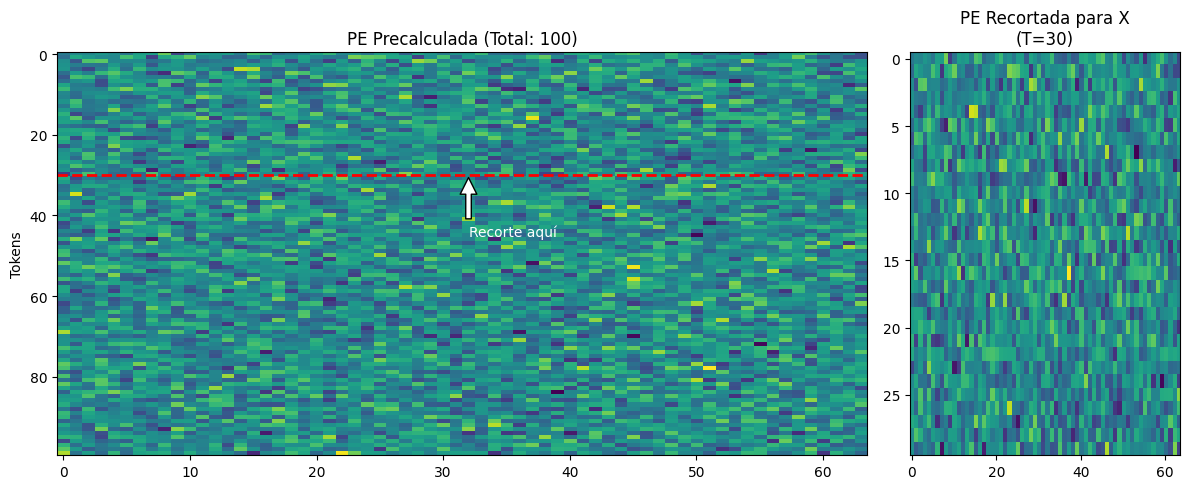

Forma de x: torch.Size([1, 30, 64])
Forma de pe_sliced: torch.Size([1, 30, 64])


In [9]:
import torch
import matplotlib.pyplot as plt

# 1. Definir dimensiones
B, T_max, T_actual, D = 1, 100, 30, 64

# 2. Simular la matriz precalculada (pe) y la entrada (x)
pe = torch.randn(1, T_max, D)  # Precalculada para 100 tokens
x = torch.zeros(B, T_actual, D) # Entrada real de solo 30 tokens

# 3. La operación de tu código
pe_sliced = pe[:, :x.size(1)] # Resultado: (1, 30, 64)

# --- Visualización ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})

# Mostrar matriz completa y el recorte
ax1.imshow(pe[0].numpy(), cmap='viridis', aspect='auto')
ax1.axhline(y=T_actual, color='red', linestyle='--', linewidth=2)
ax1.set_title(f"PE Precalculada (Total: {T_max})")
ax1.set_ylabel("Tokens")
ax1.annotate('Recorte aquí', xy=(D/2, T_actual), xytext=(D/2, T_actual+15),
             arrowprops=dict(facecolor='white', shrink=0.05), color='white')

# Mostrar el resultado final que se suma a X
ax2.imshow(pe_sliced[0].numpy(), cmap='viridis', aspect='auto')
ax2.set_title(f"PE Recortada para X\n(T={x.size(1)})")

plt.tight_layout()
plt.show()

print(f"Forma de x: {x.shape}")
print(f"Forma de pe_sliced: {pe_sliced.shape}")


In [12]:
import torch

# 1. Configuración: Batch de 2, Secuencia de 3 tokens, Dimensión de 4
B, T, D = 2, 3, 4

# 2. Simulamos la PE precalculada (ej. máximo 10 tokens)
# Usamos números enteros para que sea fácil ver el recorte
pe = torch.arange(10).view(-1, 1).expand(10, D).unsqueeze(0) 
# pe shape: (1, 10, 4) -> Contiene filas de 0s, luego 1s, 2s...

# 3. Nuestra entrada 'x' (Batch de 2, solo 3 tokens)
x = torch.zeros(B, T, D) 

# 4. LA OPERACIÓN CLAVE:
# Recortamos pe para que coincida con T=3
pe_sliced = pe[:, :x.size(1)] 

# Sumamos
resultado = x + pe_sliced

print(x)
print(pe)
print(f"Dimensiones de x: {list(x.shape)}")
print(f"Dimensiones de pe original: {list(pe.shape)}")
print(f"Dimensiones de pe_sliced: {list(pe_sliced.shape)}")
print("-" * 30)
print("Resultado final (x + pe_sliced):")
print(resultado)


tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])
tensor([[[0, 0, 0, 0],
         [1, 1, 1, 1],
         [2, 2, 2, 2],
         [3, 3, 3, 3],
         [4, 4, 4, 4],
         [5, 5, 5, 5],
         [6, 6, 6, 6],
         [7, 7, 7, 7],
         [8, 8, 8, 8],
         [9, 9, 9, 9]]])
Dimensiones de x: [2, 3, 4]
Dimensiones de pe original: [1, 10, 4]
Dimensiones de pe_sliced: [1, 3, 4]
------------------------------
Resultado final (x + pe_sliced):
tensor([[[0., 0., 0., 0.],
         [1., 1., 1., 1.],
         [2., 2., 2., 2.]],

        [[0., 0., 0., 0.],
         [1., 1., 1., 1.],
         [2., 2., 2., 2.]]])
